In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from subprocess import Popen, PIPE, STDOUT
import matplotlib.pyplot as plt
import os
from copy import deepcopy
import galsim 

In [3]:
#directories that would be using 
repo = '/Users/Ismael/code/lensing/SMFF/'
os.chdir(repo)

In [4]:
#colormap default to use for galaxy 
cmap = 'RdYlGn'

In [5]:
def showImage(image,ax=None):
    if ax is None: 
        plt.imshow(image, cmap=cmap,vmax=abs(image).max(),vmin=-abs(image).max(),interpolation='None')
    else: 
        ax.imshow(image, cmap=cmap,vmax=abs(image).max(),vmin=-abs(image).max(),interpolation='None')

In [6]:
latex_names =['$x_{0}$','$y_{0}$','$f$','$hlr$','$e_{1}$','$e_{2}$']

## Analysis of a single galaxy

### Generating a galaxy file

In [7]:
#parameters of galaxy to draw. 
model = 'gaussian' #possible options of model and psf_model are in documentation. 
psf_model = 'psf_gaussian'
e1 = 0.
e2 = 0. 
hlr = 1.0 
psf_fwhm = .7
snr = 20. 

#project folder name where you want to write galaxy information 
project1 = 'project-tutoria145'

#image parameters 
pixel_scale=.2 
nx = 40
ny = 40 


In [8]:
cmd = 'python generate.py -p {0} -gal 1 --galaxy-model {1} --psf_model {2}  --e1 {3} --e2 {4} --y0 0 --x0 0 \
--flux 1. --psf_flux 1. --hlr {5} --psf_fwhm {6} --snr {7}'.format(project1,model,psf_model,e1,e2,hlr,psf_fwhm,snr)
p = Popen(cmd, shell=True, stdin=PIPE, stdout=PIPE, stderr=STDOUT, close_fds=True)
output = p.stdout.read()
print output

### Get fisher formalism analysis from the file

In [9]:
import analysis.fisher as fisher
import analysis.galfun as galfun

In [10]:
g_parameters = galfun.GParameters(project1) #extract parameters from file created by generate.py 
image_renderer = galfun.ImageRenderer(pixel_scale=pixel_scale,
                                      nx=nx,ny=ny)
fish = fisher.Fisher(g_parameters=g_parameters,image_renderer=image_renderer, 
                     snr=snr)

### Draw the galaxy generated 

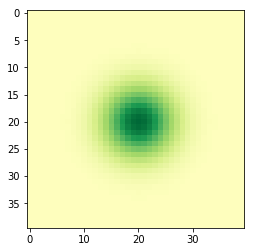

In [11]:
#get galaxy image and display it from fisher object. green is positive and red is negative 
showImage(fish.image.array)


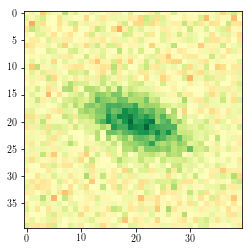

In [74]:
img,_ = galfun.addNoise(fish.image,snr=60,noise_seed = 2 )
showImage(img.array)

### Draw the partial derivatives of the image 

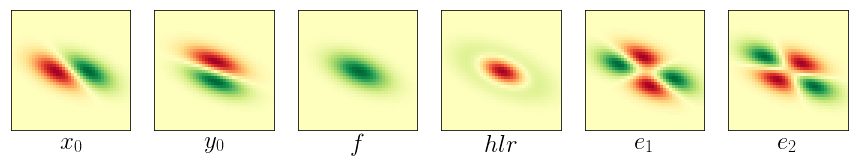

In [100]:
#draw partials.
nrow,ncol = 1,6
fig = plt.figure(figsize=(15,15))
for i,name in enumerate(fish.param_names):
    image = fish.derivatives_images[name]
    plt.subplot(nrow,ncol,i+1)
    showImage(image)
    #plt.title('Partial derivative with respect to {0}'.format(name[:-2]),fontsize=14)
    #plt.colorbar()
    plt.tick_params(
    axis='both',     
    which='both',      
    bottom='off',   
    top='off',        
    left='off',
    labelleft='off',
    right='off',
    labelbottom='off')
    plt.xlabel(latex_names[i],size=25)
    plt.rc('text', usetex=True)

### Draw the fisher matrix images 

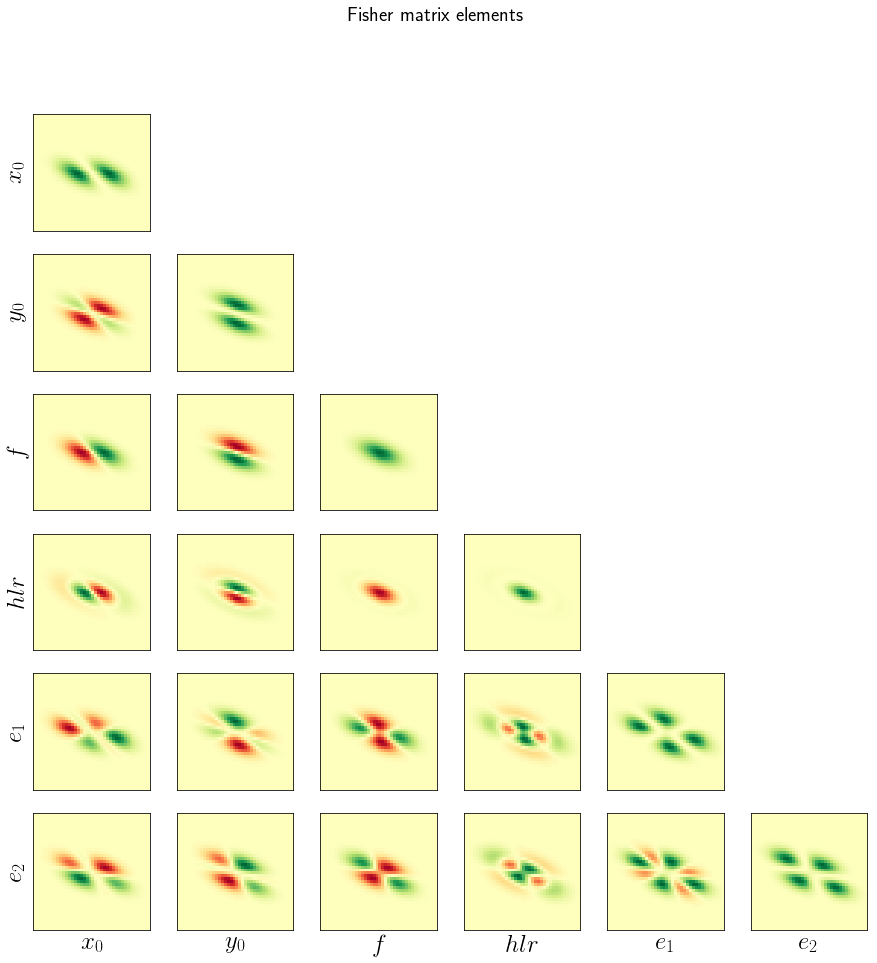

In [101]:
figure = plt.figure(figsize=(15,15))
figure.suptitle('Fisher matrix elements',
                fontsize=20)
for i in range(fish.num_params):
    for j in range(fish.num_params):
        if i >= j:
            ax = figure.add_subplot(fish.num_params,
                                    fish.num_params,
                                    fish.num_params * i + j + 1)
            showImage(fish.fisher_matrix_images[
                          fish.param_names[i],
                          fish.param_names[j]
                      ],ax)
            
                 
            if j == 0: 
                plt.tick_params(
                axis='both',     
                which='both',      
                bottom='off',   
                top='off',        
                left='off',
                labelleft='off',
                right='off',
                labelbottom='off')
                plt.ylabel(latex_names[i],size=25)
            if i == fish.num_params-1: 
                plt.tick_params(
                axis='both',     
                which='both',      
                bottom='off',   
                top='off',        
                left='off',
                labelleft='off',
                right='off',
                labelbottom='off')
                plt.xlabel(latex_names[j],size=25)
            if i!= 0 and j!= fish.num_params-1: 
                plt.tick_params(
                axis='both',     
                which='both',      
                bottom='off',   
                top='off',        
                left='off',
                labelleft='off',
                right='off',
                labelbottom='off')
            plt.rc('text', usetex=True)

### Draw the bias images 

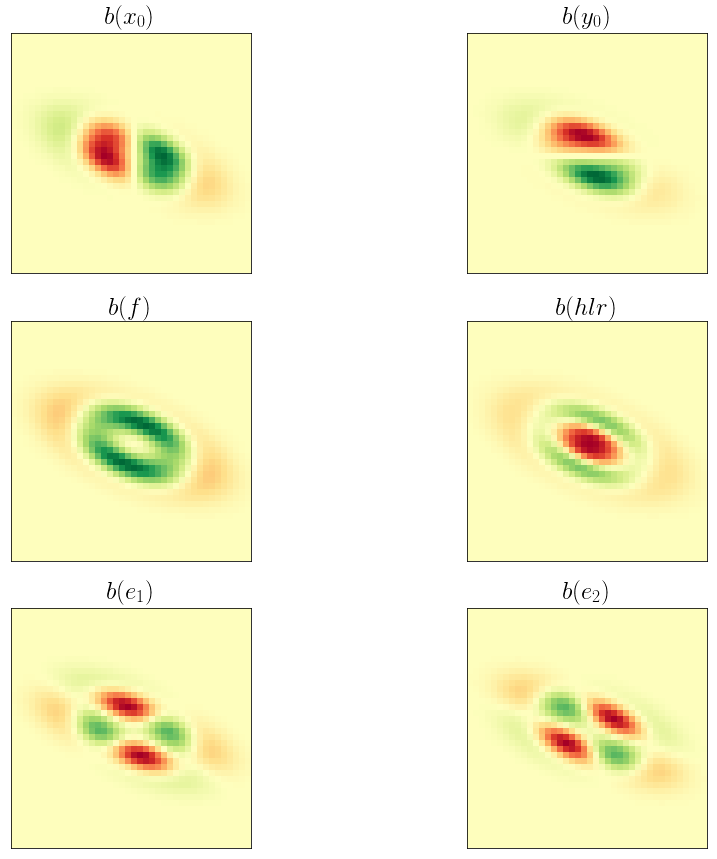

In [102]:
#draw bias images.
nrow,ncol = 3,2
fig = plt.figure(figsize=(15,15))
for i,name in enumerate(fish.param_names):
    image = fish.bias_images[name]
    plt.subplot(nrow,ncol,i+1)
    showImage(image)
    plt.title('$b(${0}$)$'.format(latex_names[i]),fontsize=25)
    #plt.colorbar()
    plt.tick_params(
    axis='both',     
    which='both',      
    bottom='off',   
    top='off',        
    left='off',
    labelleft='off',
    right='off',
    labelbottom='off')
    plt.rc('text', usetex=True)

### Bias as a function of size (more complicated example) 

In [18]:
snr_norm = 20 #nominal snr to use. 
def bias_Size(fish,image_renderer,params, num_params):
    """Plot of bias*(snr_norm/snr)**2 as a function of hlr/psf_fwhm with a fixed snr."""

    steps = 25
    x_range = (.2, 1.5)  # x = hlr_gal / psf_fwhm
    xs = np.linspace(x_range[0], x_range[1], steps)
    figure = plt.figure(figsize=(40, 40))
    id_params = deepcopy(fish.g_parameters.id_params)
    snr = fish.snr #normally use 20.
    figure.suptitle('Plot of ' + r'$b(a_{i})' + r'\left(' +
                    str(snr_norm) + r'/snr\right)^{2}$' +
                    'as a function of ' + r'hlr/fwhm$_{psf}$', fontsize=40)
    ys = {} # y= bias*snr^2
    for x in xs:
        gal_id = id_params.keys()[0]
        hlr = x * id_params[gal_id]['psf_fwhm']
        id_params[gal_id]['hlr'] = hlr
        g_parameters = galfun.GParameters(id_params=id_params)
        new_fish = fisher.Fisher(g_parameters,image_renderer, snr)
        biases = new_fish.biases
        for i,param in enumerate(params):
            if param not in ys:
                ys[param] = []
            bias = biases[param]
            y = bias
            ys[param].append(y)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.28, hspace=None)



    #do not plot x0 and y0
    extra = r'$\left(' + str(snr_norm) + r'/snr\right)^{2}$'
    y_names = [r'$b(flux)$',
                r'$b(hlr)$', r'$b(e_{1})$',
                r'$b(e_{2})$']
    units = ['$10^{-3}$','$10^{-1} \rm arcseconds$', '$10^{-2}$', '$10^{-2}$']
    y_titles = [elt + extra + '  [{0}]'.format(unit) for elt,unit in zip(y_names,units)]
    x_titles = [r'hlr/fwhm$_{psf}$'] * 6
    ranges_x = [None,[0,1.6],[0,1.6],[0,1.6]]
    ranges_y = [[-1e-3,6e-3],None,None,None]
    for i,param in enumerate(params):
        ax = figure.add_subplot(2, num_params / 2,
                                i + 1)
        ax.plot(xs, ys[param],'-o')
        ax.scatter(xs,ys[param],s=40)
        ax.set_xticks(np.linspace(0,1.6,5)) 

        #ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel(x_titles[i], fontsize=50)
        ax.set_ylabel(y_titles[i], fontsize=50)
        ax.tick_params(labelsize=40)
        ax.get_yaxis().get_offset_text().set_size(40)
        #scientic notation force.
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        
        ax.tick_params(which='both', width=3,length = 12)
        plt.axhline(0,color='r')
        if ranges_x[i] != None: plt.xlim(ranges_x[i])
        if ranges_y[i] != None: plt.ylim(ranges_y[i])

    plt.rc('text', usetex=True)


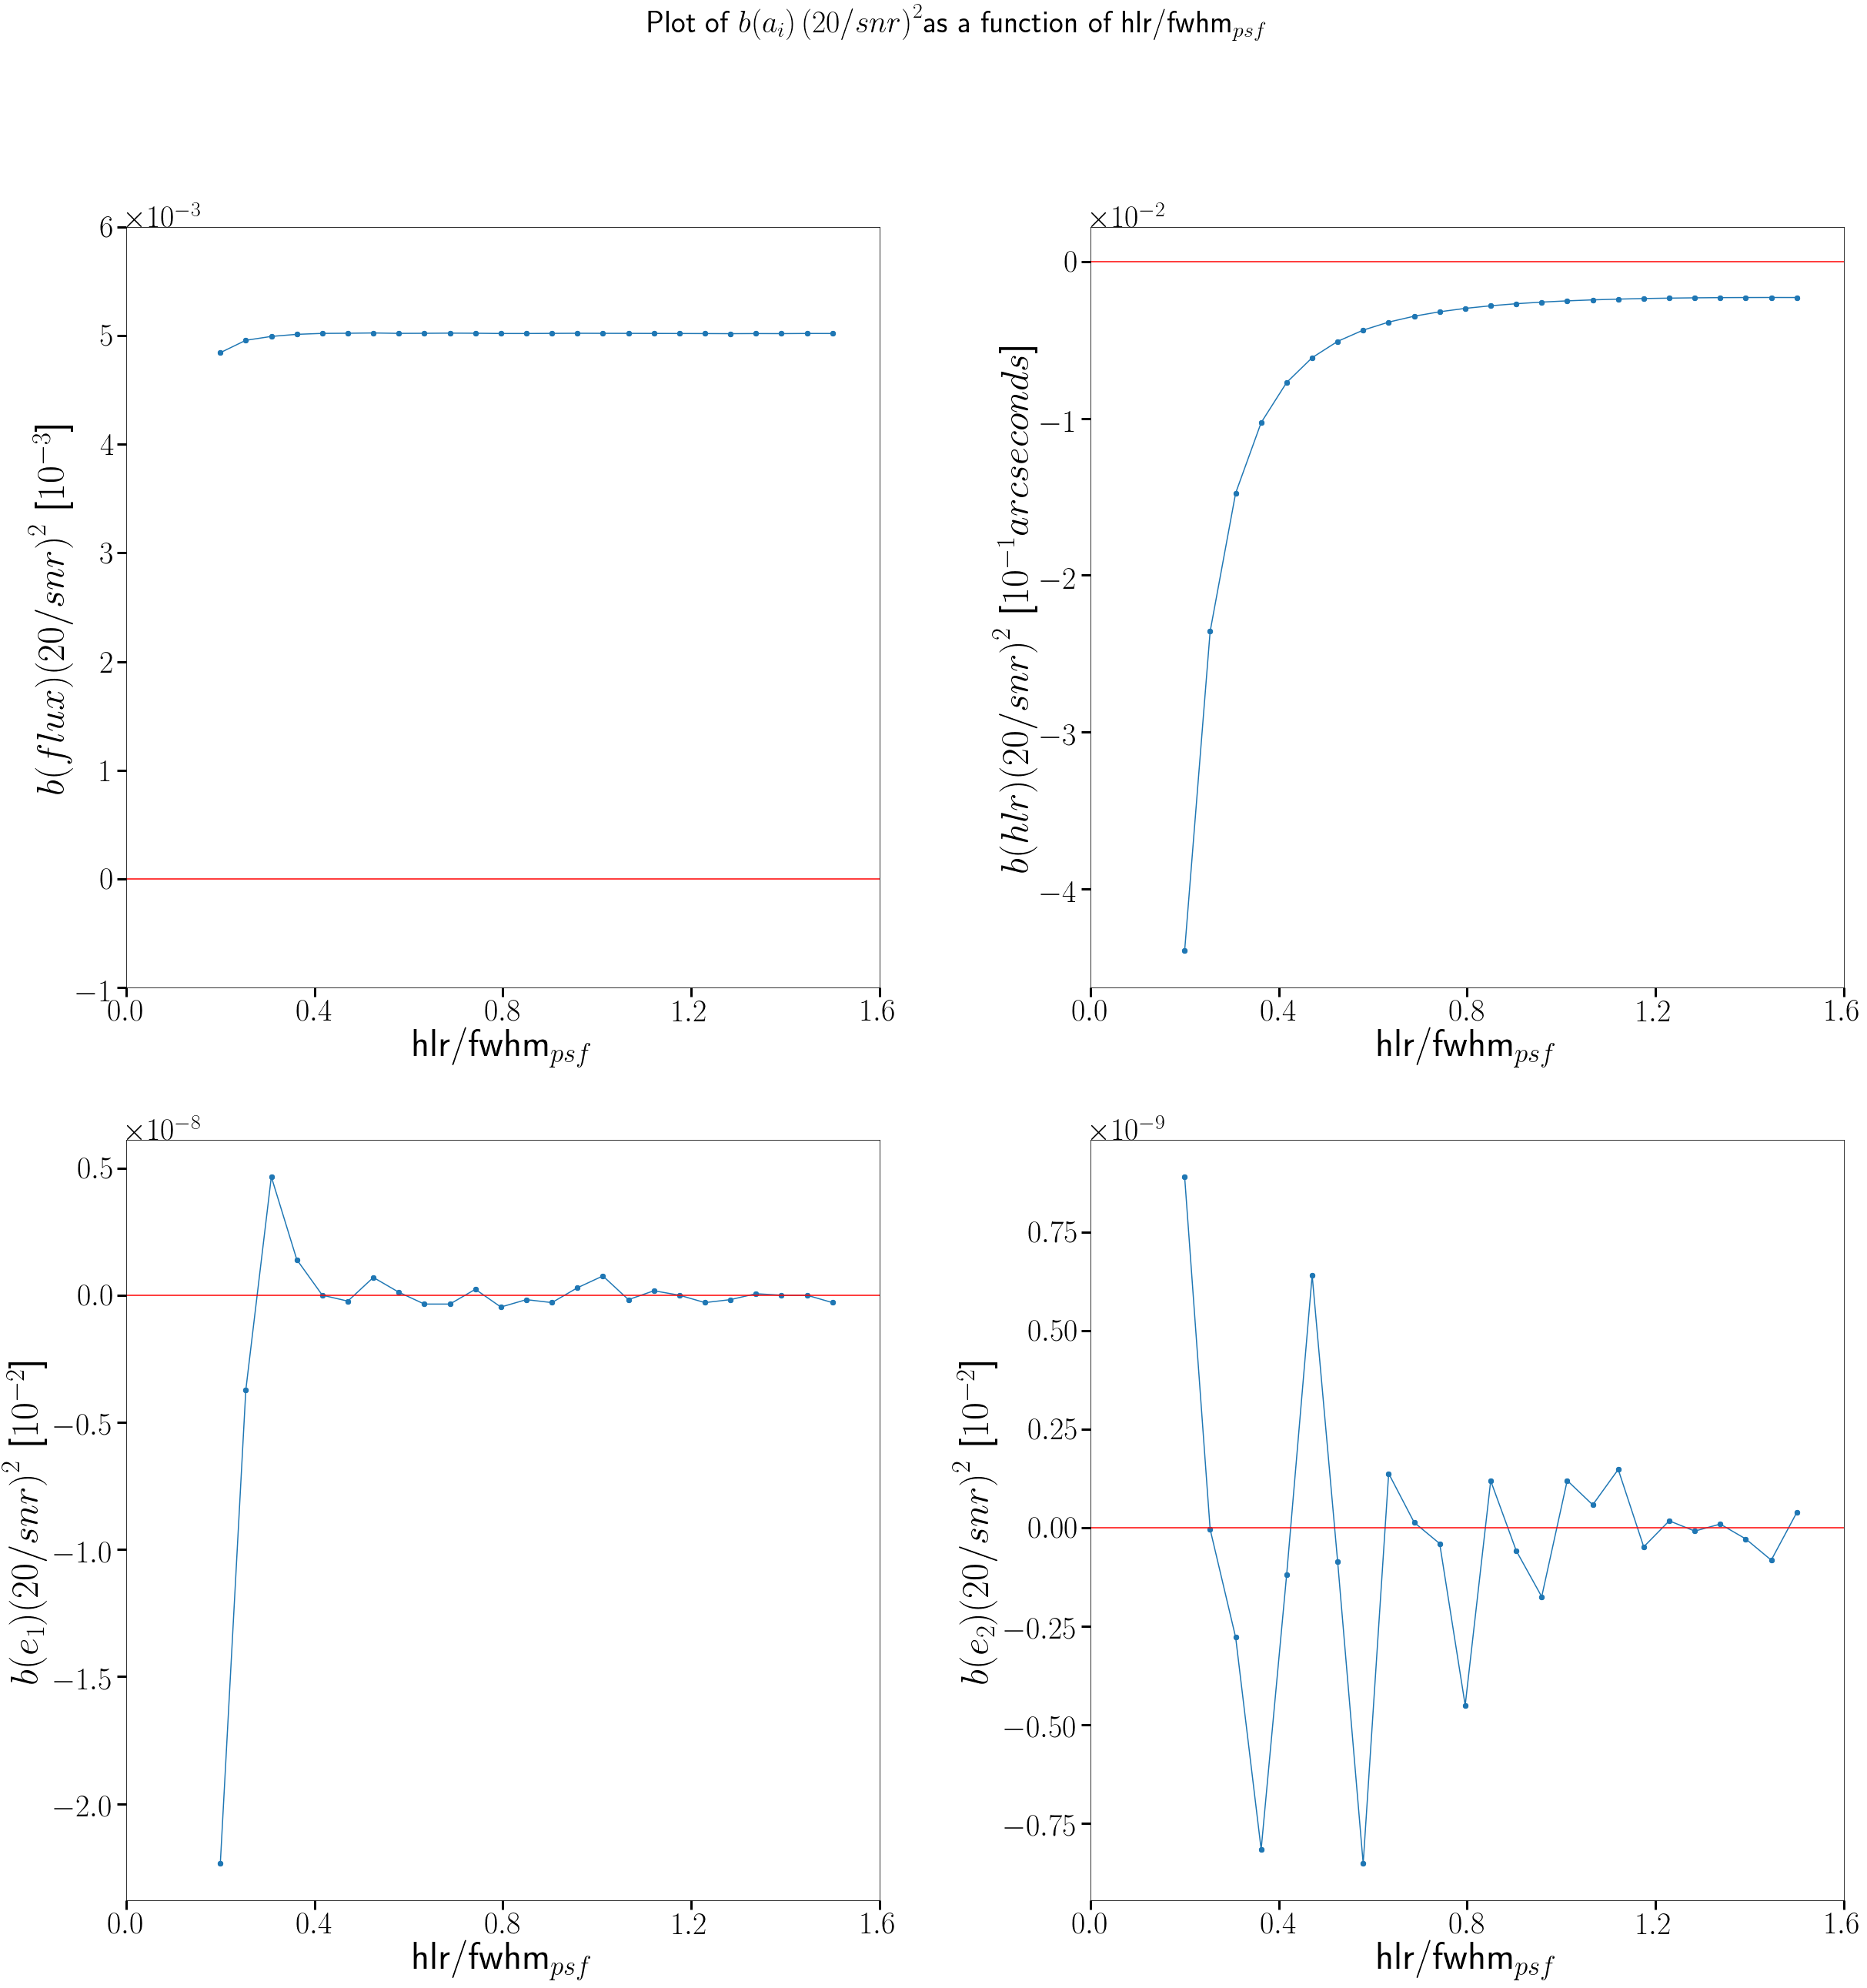

In [19]:
bias_Size(fish,image_renderer,fish.param_names[2:], fish.num_params-2)

In [24]:
#bias on parameters as a function of a component of ellipticity.
snr_norm = 20
def bias_ellipticity(fish,image_renderer,params, num_params):
    """Plot of bias*(snr_norm/snr)**2 as a function of e1 (all other parameters fixed.)"""

    steps = 30
    x_range = (-.9, .9)  #x = e1 
    xs = np.linspace(x_range[0], x_range[1], steps)
    figure = plt.figure(figsize=(30, 30))
    id_params = deepcopy(fish.g_parameters.id_params)
    figure.suptitle('Plot of ' + r'$b(a_{i})' + r'\left(' +
                    str(snr_norm) + r'/snr\right)^{2}$' +
                    ' as a function of ' + r'$e_{1}$', fontsize=40)
    ys = {} # y= bias*snr2
    for x in xs:
        gal_id = id_params.keys()[0]
        id_params[gal_id]['e1'] = x
        g_parameters = galfun.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters,image_renderer, snr)
        biases = fish.biases
        for i,param in enumerate(params):
            if param not in ys:
                ys[param] = []
            bias = biases[param]
            ys[param].append(bias)


    #do not plot x0 and y0
    units = ['$10^{-2}$','$10^{-3} \rm arcseconds$', '$10^{-3}$', '$10^{-3}$']
    extra = r'$\left(' + str(snr_norm) + r'/snr\right)^{2}$'
    y_names = [r'$b(flux)$',
                r'$b(hlr)$', r'$b(e_{1})$',
                r'$b(e_{2})$']
    y_titles = [elt + extra + "  [{0}]".format(unit) for (elt,unit) in zip(y_names,units)]
    x_titles = [r'$e_{1}$'] * 4
    for i,param in enumerate(params):
        ax = figure.add_subplot(2, num_params / 2,
                                i + 1)
        ax.plot(xs, ys[param],'-o')
        #ax.set_title(titles[i], fontsize=14)
        ax.set_xlabel(x_titles[i], fontsize=40)
        ax.set_ylabel(y_titles[i], fontsize=40)
        ax.tick_params(labelsize=30)
        ax.tick_params(which='both', width=3,length = 12)
        ax.get_yaxis().get_offset_text().set_size(60)
        #scientic notation force.
        ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
        plt.axhline(0,color='r')




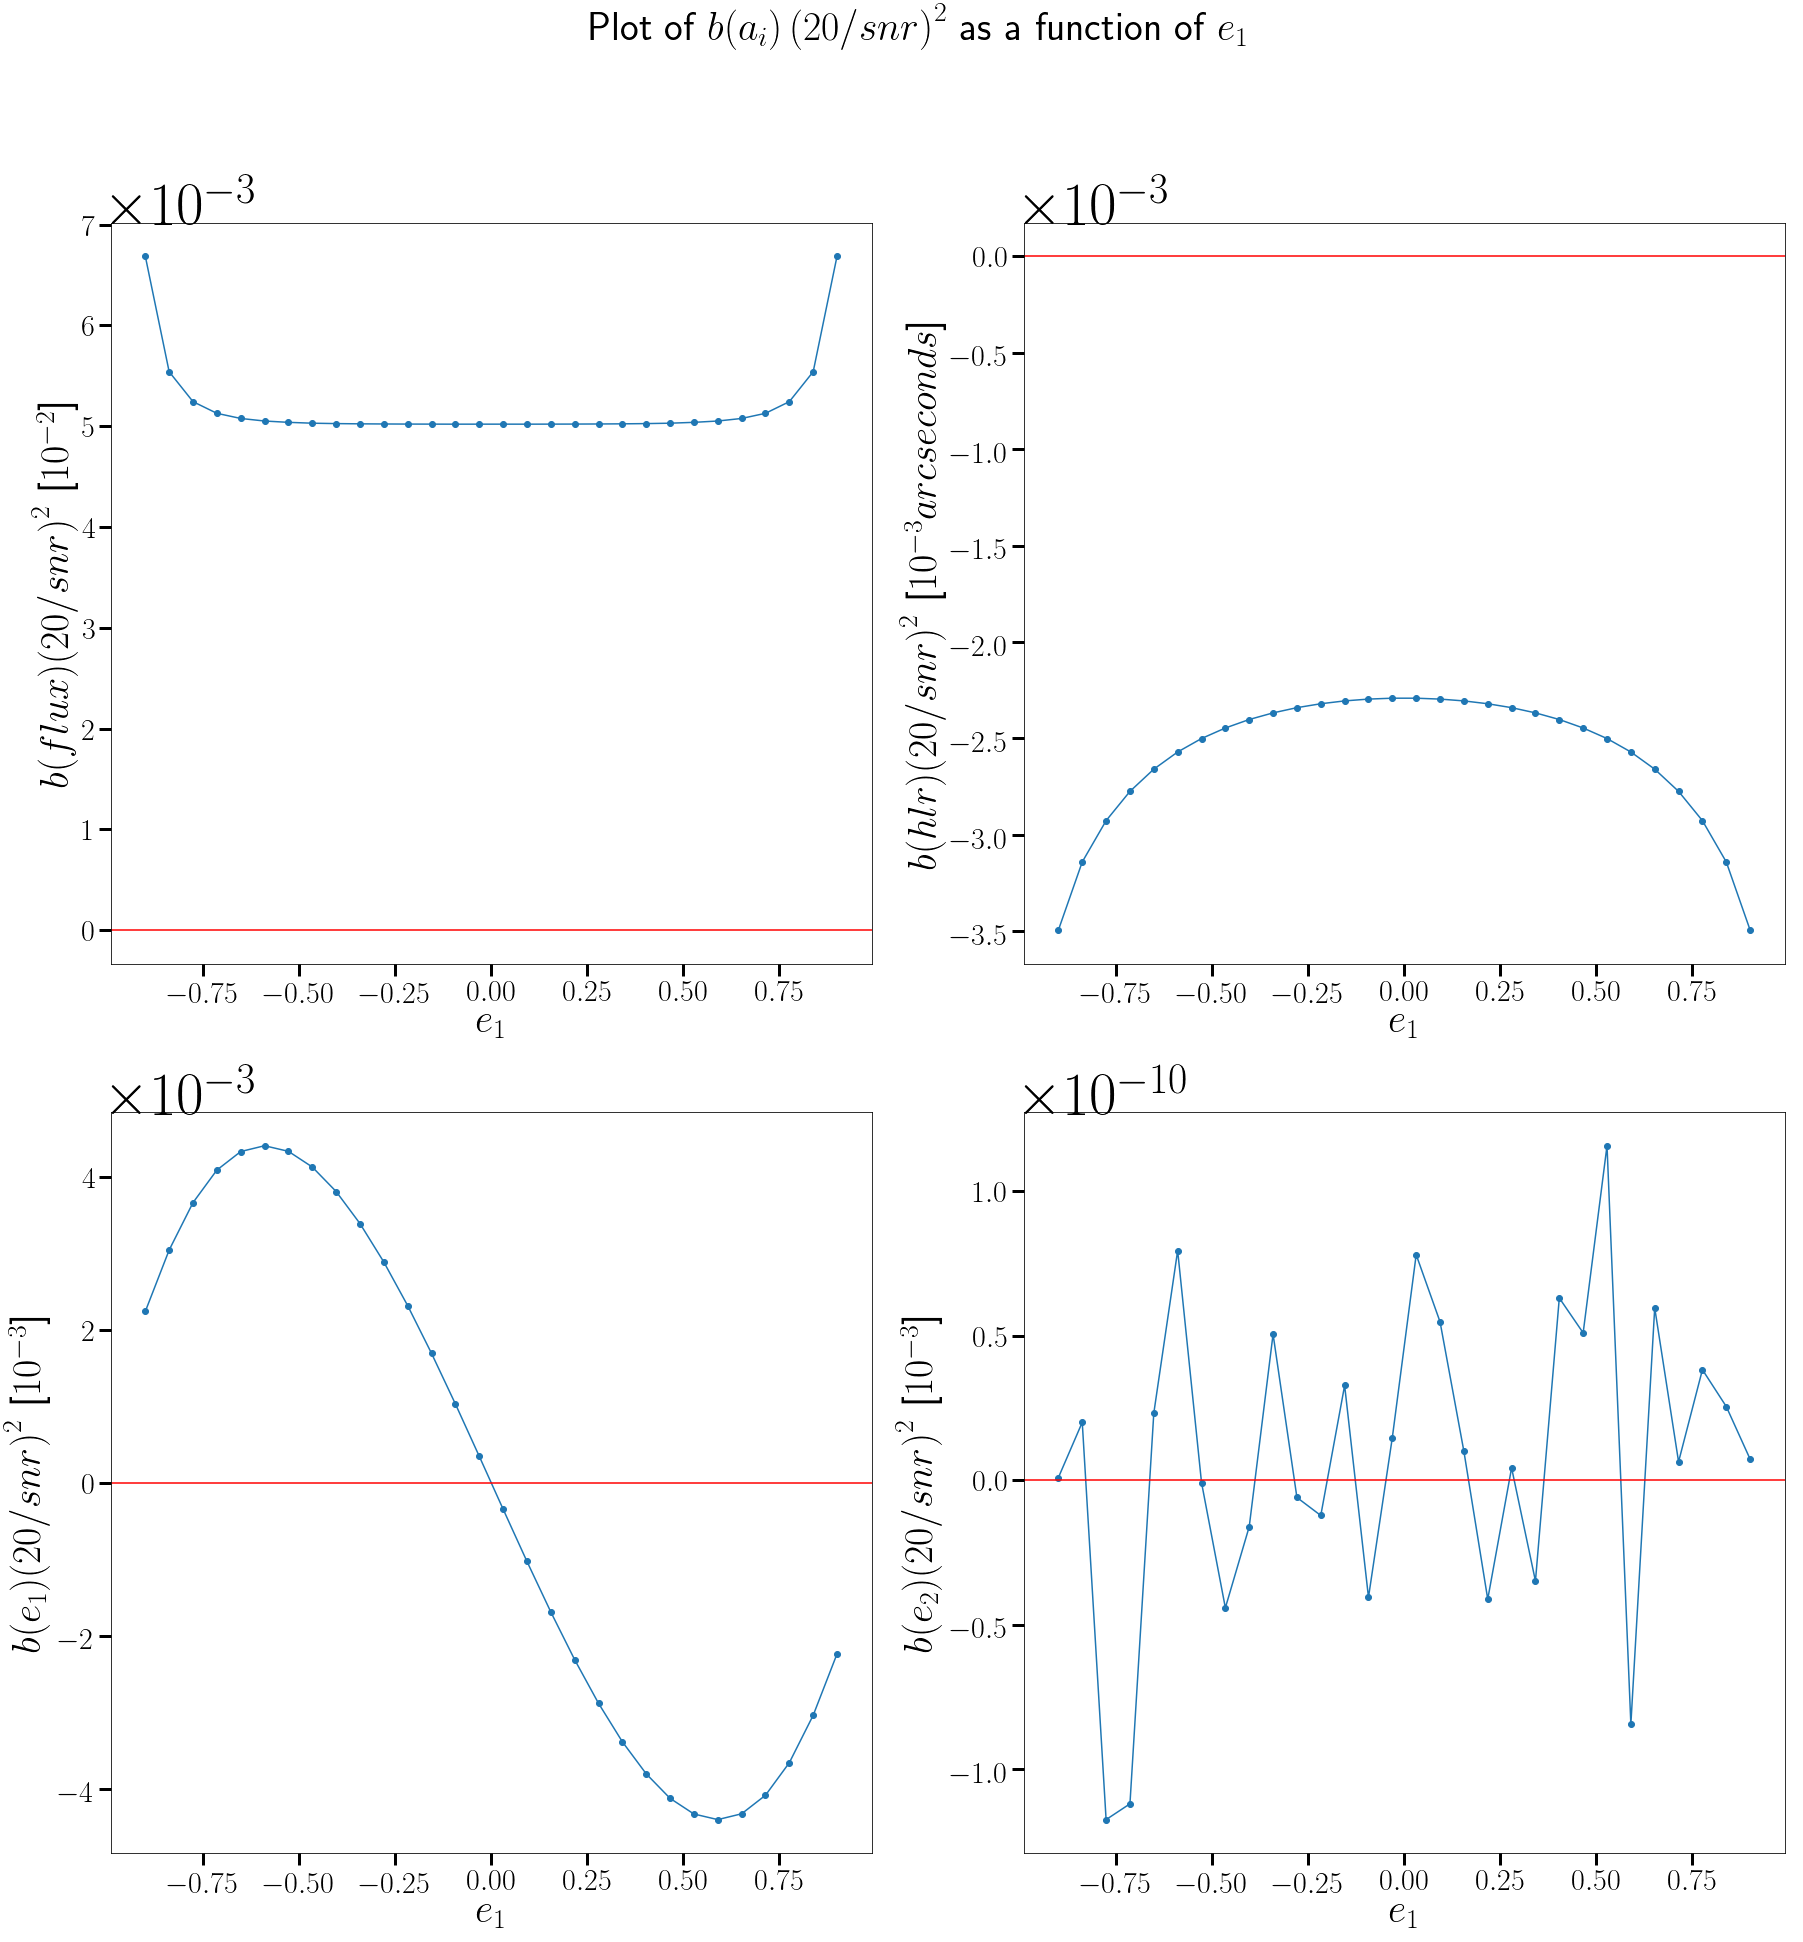

In [25]:
bias_ellipticity(fish,image_renderer,fish.param_names[2:], fish.num_params-2)

### 3d-map of bias on parameters as a function of ellipticity

In [82]:
#bias on parameters as a function of a component of ellipticity.
snr_norm = 20
def bias_ellipticity3d(fish,image_renderer):
    """Plot of bias*(snr_norm/snr)**2 as a function of e1 (all other parameters fixed.)"""

    radius_steps = 12
    steps_per_radius = 9
    e_range = (0.,.90) #e = e1**2 + e2**2 
    angle_range = (0, 2*np.pi) 
    es = np.linspace(e_range[0], e_range[1], steps_per_radius)
    angles = list(np.linspace(angle_range[0], angle_range[1], steps_per_radius))
    angles.pop() #remove 2pi angle redundancy.
    xs = [] #e1
    ys = [] #2
    for e in es: 
        for angle in angles:
            e1 = e*np.cos(angle)
            e2= e*np.sin(angle)
            xs.append(e1)
            ys.append(e2)
    figure = plt.figure(figsize=(30, 30))
    id_params = deepcopy(fish.g_parameters.id_params)
    figure.suptitle('Plot of ' + r'$b(a_{i})' + r'\left(' +
                    str(snr_norm) + r'/snr\right)^{2}$' +
                    ' as a function of ' + r'$e_{1},e_{2}$', fontsize=40)
    zs = {} # y= bias*snr2
    for x,y in zip(xs,ys):
        gal_id = id_params.keys()[0]
        id_params[gal_id]['e1'] = x
        id_params[gal_id]['e2'] = y
        g_parameters = galfun.GParameters(id_params=id_params)
        fish = fisher.Fisher(g_parameters,image_renderer, snr)
        biases = fish.biases
        for i,param in enumerate(fish.param_names):
            if param not in zs:
                zs[param] = []
            bias = biases[param]
            zs[param].append(bias)

    #do not plot x0 and y0
    extra = r'$\left(' + str(snr_norm) + r'/snr\right)^{2}$'
    y_names = [r'$b(x_{0})$', r'$b(y_{0})$', r'$b(flux)$',
                r'$b(hlr)$', r'$b(e_{1})$',
                r'$b(e_{2})$']
    y_titles = [r'$e_{2}$'] * 6
    x_titles = [r'$e_{1}$'] * 6
    
    for i,param in enumerate(fish.param_names):
        ax = figure.add_subplot(2, fish.num_params / 2,i + 1,aspect='equal')
        s = ax.scatter(xs, ys, c=zs[param],s=60)
        ax.set_xlabel(x_titles[i], fontsize=40)
        ax.set_ylabel(y_titles[i], fontsize=40)
        ax.tick_params(labelsize=20)
        plt.title('Bias on {0}'.format(param[:-2]), fontsize=30)
        cb = plt.colorbar(s,extend='both')
        cb.ax.tick_params(labelsize=20)
        plt.xlim(-1,1)
        plt.ylim(-1,1)
        cb.ax.yaxis.get_offset_text().set_size(20)
        cb.formatter.set_powerlimits((0, 0))
        cb.update_ticks()
#         cb.ax.yaxis.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))

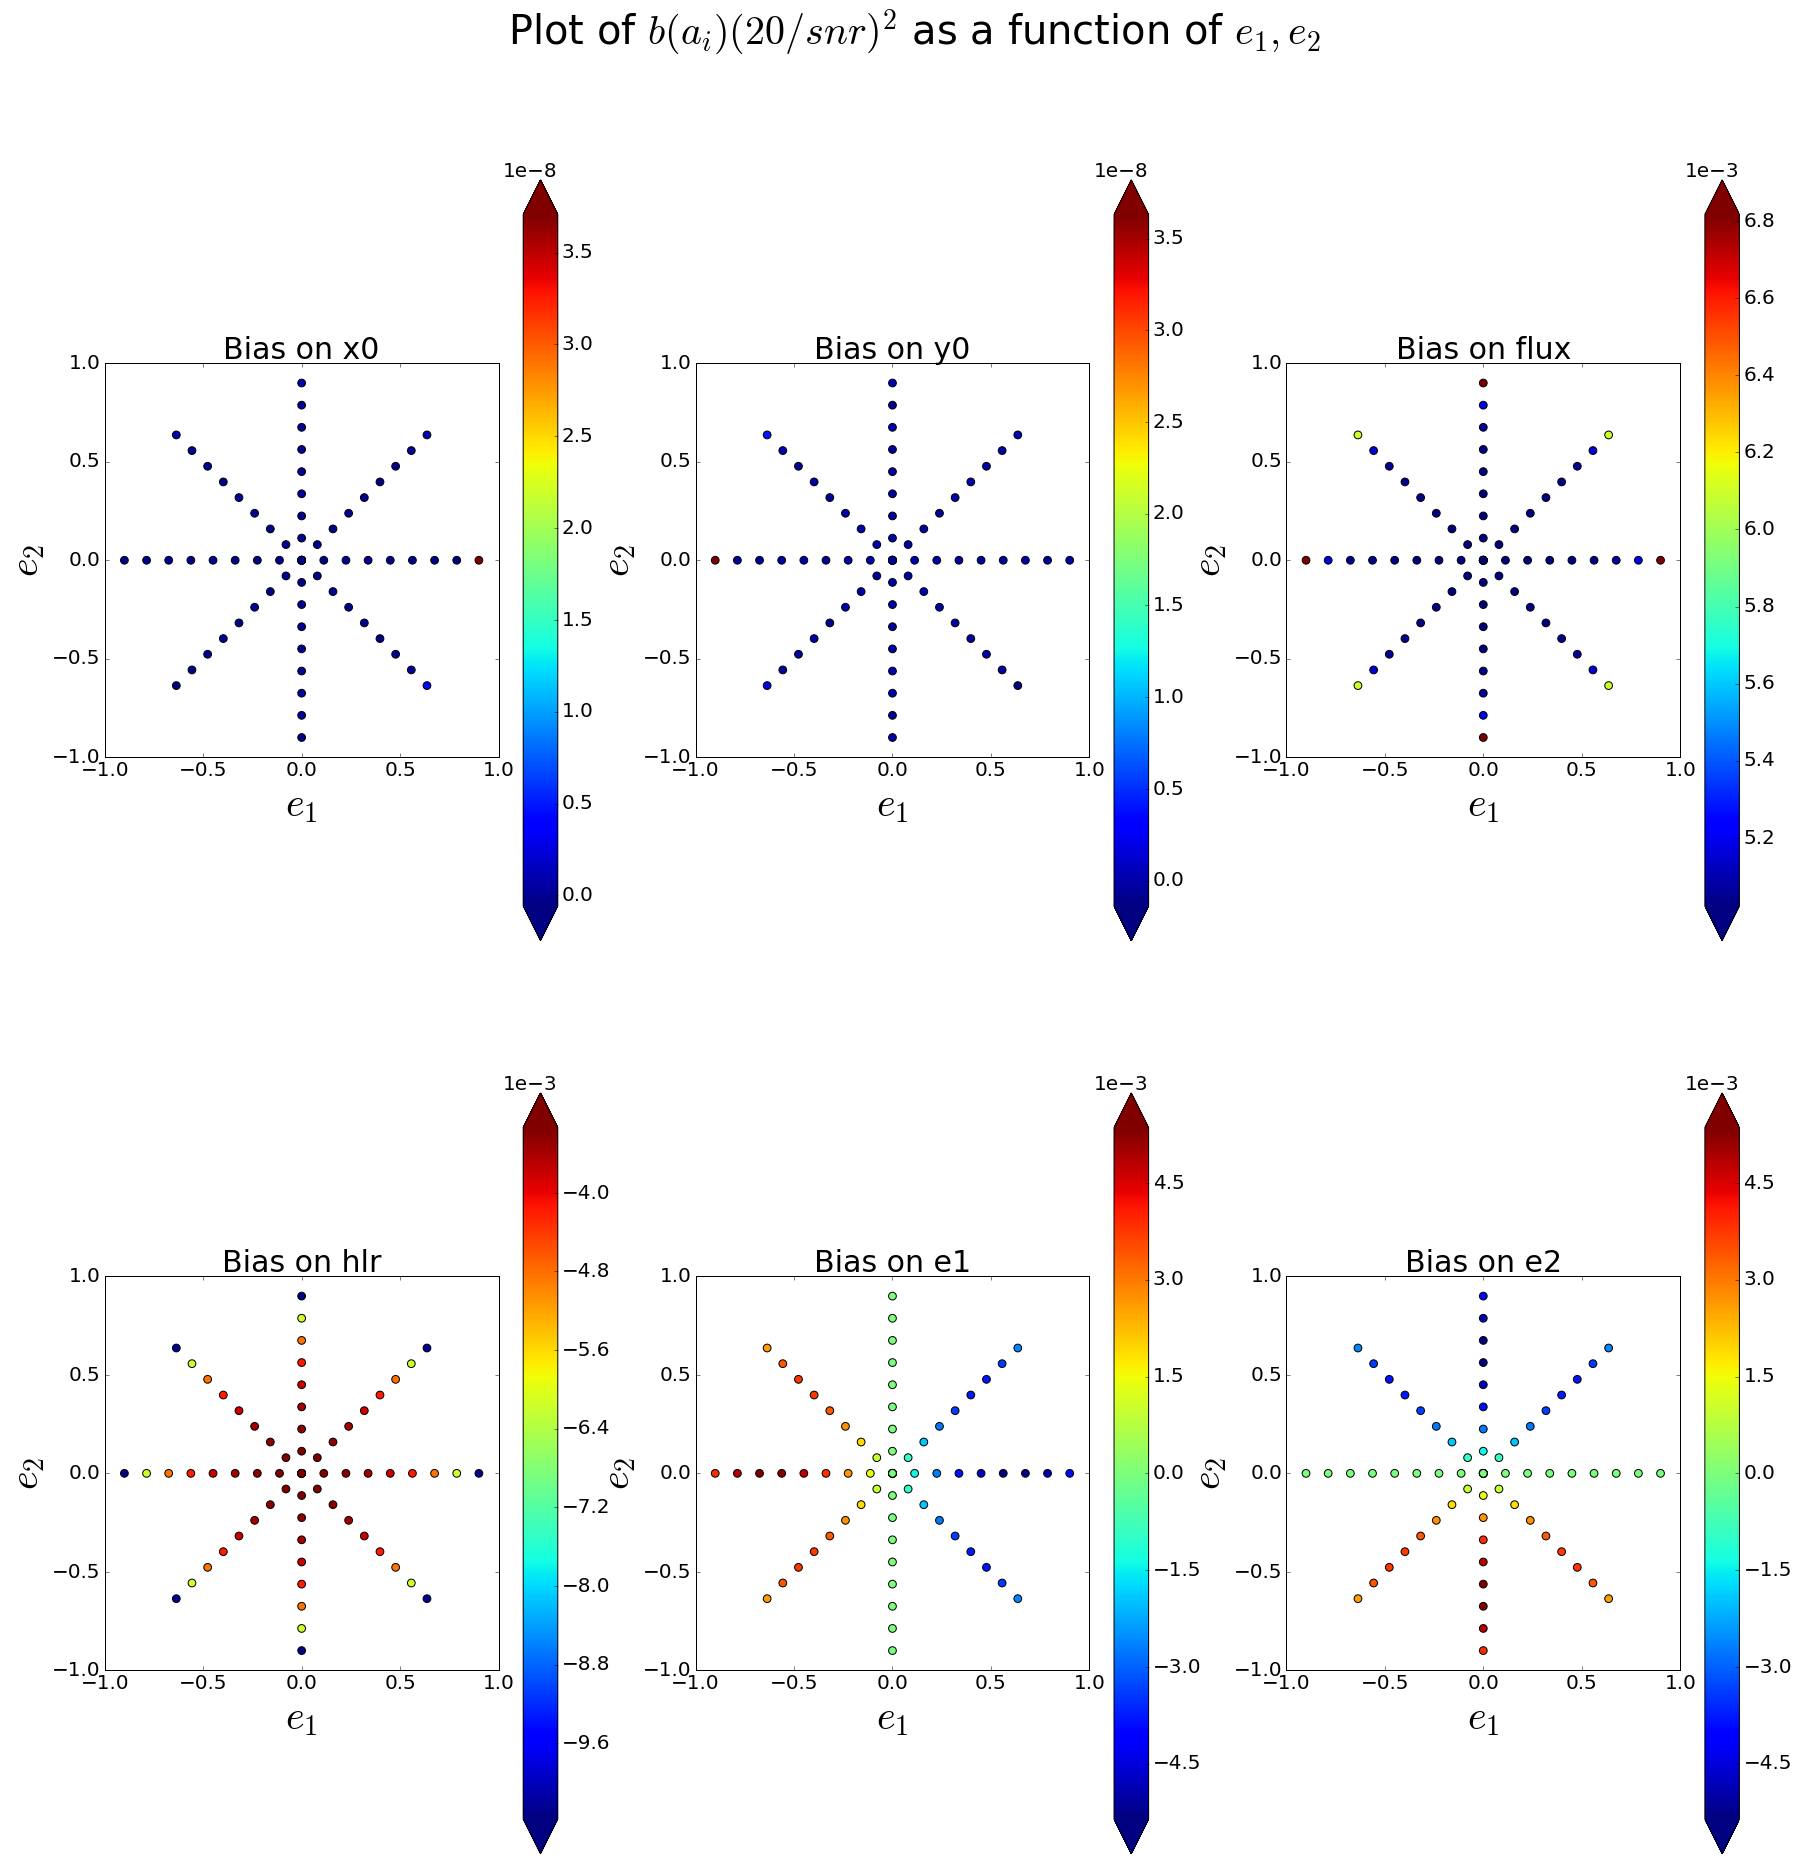

In [83]:
bias_ellipticity3d(fish,image_renderer)